In [2]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
import scipy.signal

SMALL_SIZE = 12
MEDIUM_SIZE = 14
LARGE_SIZE = 16

plt.rc("font",size=LARGE_SIZE)
plt.rc("axes",titlesize=LARGE_SIZE)
plt.rc("axes",labelsize=LARGE_SIZE)
plt.rc("xtick",labelsize=LARGE_SIZE)
plt.rc("ytick",labelsize=LARGE_SIZE)
plt.rc("legend",fontsize=LARGE_SIZE)
plt.rc("figure",titlesize=LARGE_SIZE)

In [3]:
### Physical Constant ###
### DO NOT EDIT ###

# Specific Ionic constants     (l/g_ion)

HNa  = -0.550
HCa  = -0.303
HMg  = -0.314
HH   = -0.774
HCl  =  0.844
HCO3 =  0.485
HHO  =  0.941


# Molecular masses     (g/mol)

MNaCl  = 58.5
MCaCO3 = 90
MMgCl2 = 95
MNa    = 23
MCa    = 40
MMg    = 24
MCl    = 35.5
MCO3   = 60 


# Kinetic constants
   
miu_P  = 1.790      # [1/h]
Ks     = 1.030      # [g/l]
Ks1    = 1.680      # [g/l]      
Kp     = 0.139      # [g/l]
Kp1    = 0.070      # [g/l]
Rsx    = 0.607
Rsp    = 0.435
YO2    = 0.970      # [mg/mg]
KO2    = 8.86       # [mg/l]
miu_O2 = 0.5        # [1/h]
A1     = 9.5e8
A2     = 2.55e33
Ea1    = 55000      # J/mol
Ea2    = 220000     # J/mol
R      = 8.31       # J/(mol.K)


# thermodynamic constants

Kla0   = 38        # [1/h]
KT     = 100*3600  # [J/hm2K]
Vm     = 50        # [l]
AT     = 1         # [m2]
ro     = 1080      # [g/l]
ccal   = 4.18      # [J/gK]         
roag   = 1000      # [g/l]
ccalag = 4.18      # [J/gK]
deltaH = 518       # [kJ/mol O2 consumat]

 
# Initial data

mNaCl  = 500        # [g]
mCaCO3 = 100        # [g]
mMgCl2 = 100        # [g]
pH     = 6
Tiag   = 15         # [癈]


# Initial Conditions

x0 = [1000, 0.90467678228155, 12.51524128083789, 29.73892382828279, 3.10695341758232, 29.57321214183856, 27.05393890970931]


In [4]:
### Process Model Function ###
### DO NOT EDIT ###
global T_POINT, T_DELAY
T_POINT = 100 ## number of point to sample with in 1 step
T_DELAY = 3   ## time delay of the system

def model(t,vars,Fi,Fe,T_in,cS_in,Fag):
    V, cX, cP, cS, cO2, T, Tag = vars
    t_index = np.mod(t,1)
    t_index = int(t_index*T_POINT)
    ## handle both function and a list
    if callable(Fi):
        Fi = Fi(t)
    else:
        Fi = Fi[t_index]
    if callable(Fe):
        Fe = Fe(t)
    else:
        Fe = Fe[t_index]
    if callable(T_in):
        T_in = T_in(t)
    else:
        T_in = T_in[t_index]
    if callable(cS_in):
        cS_in = cS_in(t)
    else:
        cS_in = cS_in[t_index]
    if callable(Fag):
        Fag = Fag(t)
    else:
        Fag = Fag[t_index]

    c0st = 14.16 - 0.3943 * T + 0.007714 * T**2 - 0.0000646 * T**3 # [mg/l]
    
    cNa  = mNaCl/MNaCl*MNa/V
    cCa  = mCaCO3/MCaCO3*MCa/V
    cMg  = mMgCl2/MMgCl2*MMg/V
    cCl  = (mNaCl/MNaCl + 2*mMgCl2/MMgCl2)*MCl/V
    cCO3 = mCaCO3/MCaCO3*MCO3/V
    cH   = 10**(-pH)
    cOH  = 10**(-(14-pH))

    INa  = 0.5*cNa*((+1)**2)
    ICa  = 0.5*cCa*((+2)**2)
    IMg  = 0.5*cMg*((+2)**2)
    ICl  = 0.5*cCl*((-1)**2)
    ICO3 = 0.5*cCO3*((-2)**2)
    IH   = 0.5*cH*((+1)**2)
    IOH  = 0.5*cOH*((-1)**2)

    sumaHiIi = HNa*INa+HCa*ICa+HMg*IMg+HCl*ICl+HCO3*ICO3+HH*IH+HHO*IOH
    cst  = c0st * 10**(-sumaHiIi)
    Kla  = Kla0*(1.024**(T-20))
    rO2 = miu_O2 * cO2 * cX/YO2/(KO2 + cO2)*1000  # mg/lh
    miu_X = A1*np.exp(-Ea1/R/(T+273)) - A2*np.exp(-Ea2/R/(T+273))

    dV   = Fi - Fe
    dcX  = miu_X * cX * cS / (Ks + cS) * np.exp(-Kp * cP) - (Fe/V)*cX     # g/(l.h)
    dcP  = miu_P * cX * cS / (Ks1 + cS) * np.exp(-Kp1 * cP) - (Fe/V)*cP   # g/(l.h)
    dcS  = - miu_X * cX * cS / (Ks + cS) * np.exp(-Kp * cP) / Rsx - miu_P * cX * cS / (Ks1 + cS) * np.exp(-Kp1 * cP) / Rsp + (Fi/V)*cS_in - (Fe/V)*cS                                    # g/(l.h)
    dcO2 = Kla * (cst - cO2) - rO2 - (Fe/V)*cO2                        # mg/(l.h)
    dT   = (1/32*V*rO2*deltaH - KT*AT*(T - Tag) + Fi*ro*ccal*(T_in+273) - Fe*ro*ccal*(T+273))/(ro*ccal*V)    # J/h
    dTag = (Fag*ccalag*roag*(Tiag - Tag) + KT*AT*(T - Tag)) / (Vm * roag * ccalag)                                        # J/h

    return [dV, dcX, dcP, dcS, dcO2, dT, dTag]


In [5]:
### If you are interested, the simulation is achieved by runing the model without the time delay and mannully shift the time for the model.
### The feedback is achieved by accessing the process output on previous time (time delay enables this).

## solve one step of the model, time is an array [t_initial, t_end]
def solve_step(time, x0, Fi, Fe, T_in, cS_in, Fag, result):
    t_eval = np.linspace(time[0],time[1],T_POINT)
    ### changed to BDF method stablized the oxygen concentration
    sol = scipy.integrate.solve_ivp(model, time, x0,args=(Fi,Fe,T_in,cS_in,Fag), t_eval=t_eval, method='BDF')
    if time[0] == 0:
        result = np.concatenate((result, sol.y), axis=1)
    else:
        result = np.concatenate((result, sol.y[:,1:]), axis=1)
    return result

## Find the current output of your system time is integer and returns the process data for 1 step with number of point equal to T_POINT
def current_output(time, result):
    process_time = int(time*(T_POINT-1))
    return result[:,process_time:int((time+1)*(T_POINT-1)+1)]

## Find the setpoint of your process.
def set_point(time, x0):
    result = np.zeros([7,T_DELAY*(T_POINT-1)])
    for i in range(time[1]-T_DELAY):
        if i == 0:
            x0=x0
        Fi = lambda t: 51
        Fe = lambda t: 51
        T_in = lambda t: 25
        cS_in = lambda t: 60
        Fag = lambda t: 18
        result = solve_step([i, i+1], x0, Fi, Fe, T_in, cS_in, Fag, result)
        x0 = result[:,-1]
    return result

In [6]:
## Function that runs the entie feedback loop. time is an array with [t_inital, t_end], x0 is the initial condition
def dynamic_model(time, x0):
    result_sp = set_point(time, x0)
    result = np.zeros([7,T_DELAY*(T_POINT-1)])
    for i in range(time[1]-T_DELAY):
        ##Cover the edge case
        if i == 0:
            x0=x0

        V, Cx, Cp, Cs, Co2, T, Tag = current_output(i,result) # find the current output of the process
        Vsp, Cxsp, Cpsp, Cssp, Co2sp, Tsp, Tagsp = current_output(i,result_sp) # Find the current setpoint of the process
        ## process input, you may need to specify as disturbance in the problem statement or you need to use controller to adjust the input
        Fi = lambda t: 51
        Fe = lambda t: 51
        T_in = lambda t: 25
        cS_in = lambda t: 60
        Fag = lambda t: 18

        ## Find your error

        ## Construct your transfer function


        t_eval = np.linspace(i,i+1,T_POINT) ## your transfer function should evaluate on the same time point as the model (this is your sampling point)
        
        ## Simulate your input to the model
       
        ## Your solve_step can take both a callable function for Fi, Fe, T_in, cS_in, Fag or an array of data at the given [i, i+1] time window.
        ## ie your simulated input to process can be directly feed into the solve_step, and you can also define disturbance as function and pass into the solve_step
        result = solve_step([i, i+1], x0, Fi, Fe, T_in, cS_in, Fag, result)
        x0 = result[:,-1]
    t = np.linspace(time[0],time[1],(time[1] - time[0])*(T_POINT-1)+1) ## entire sampling time for the process 
    return t, result, result_sp


In [7]:
t_final = 100 ### final time for you model
t, result, result_sp = dynamic_model([0,t_final], x0) ### run the model

### Notice, you may find offest when you do you controller, and we are trying to identiy if that's
### what pthon do or there is a small bug on the code, but it shouldn't affect your design.

<>:43: SyntaxWarning: invalid escape sequence '\c'
<>:50: SyntaxWarning: invalid escape sequence '\c'
<>:43: SyntaxWarning: invalid escape sequence '\c'
<>:50: SyntaxWarning: invalid escape sequence '\c'
/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_27509/3162908226.py:43: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel("Tank Temperature ($^{\circ} C$)")
/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_27509/3162908226.py:50: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel("Cooling Water Temperature ($^{\circ} C$)")


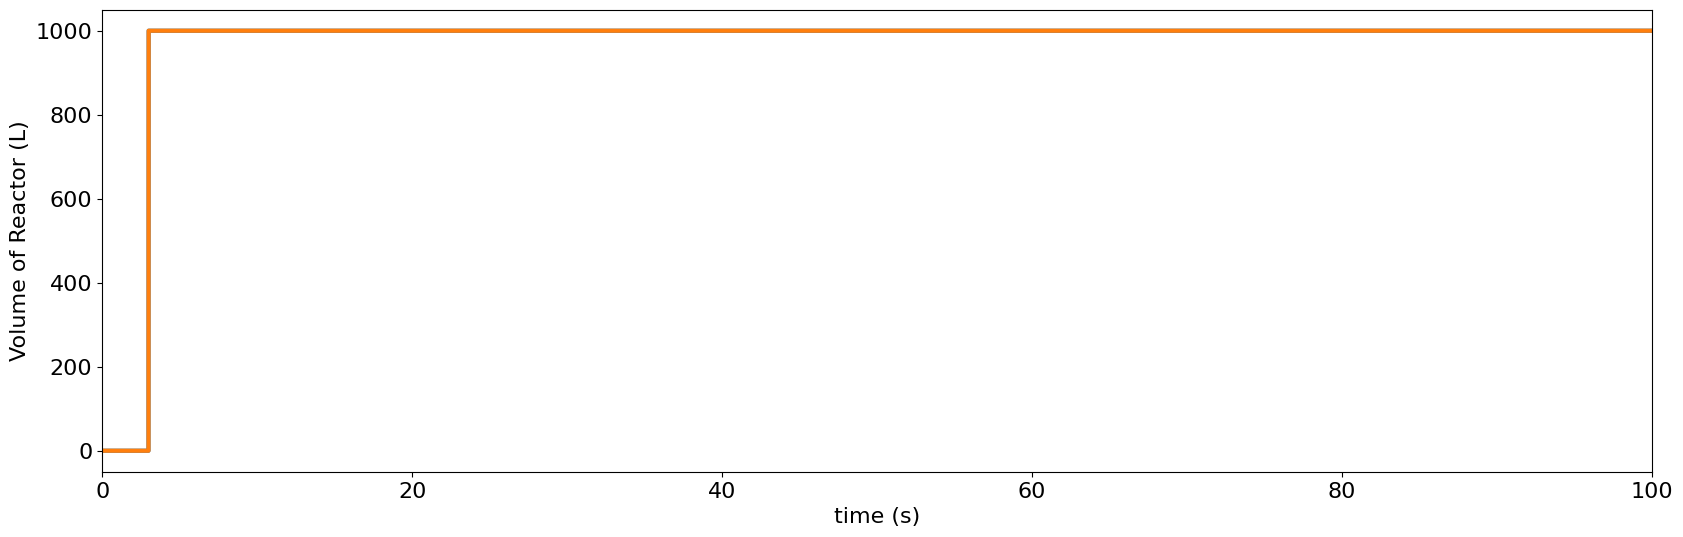

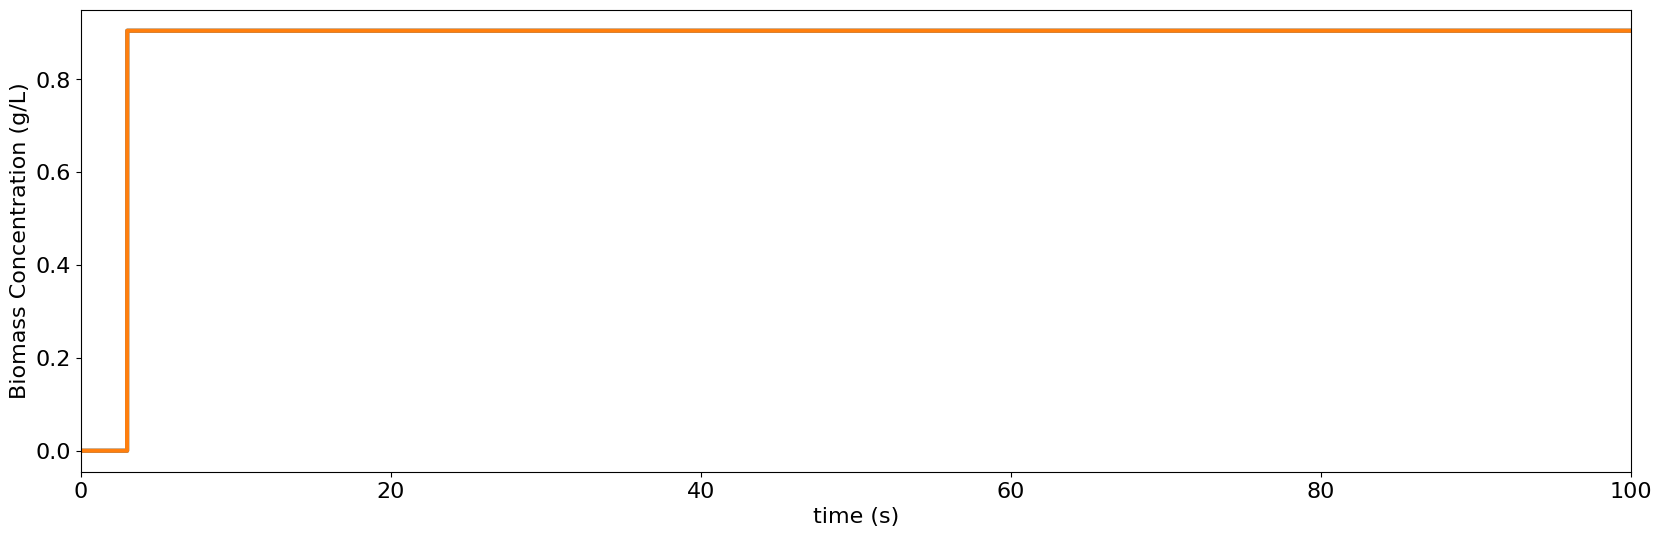

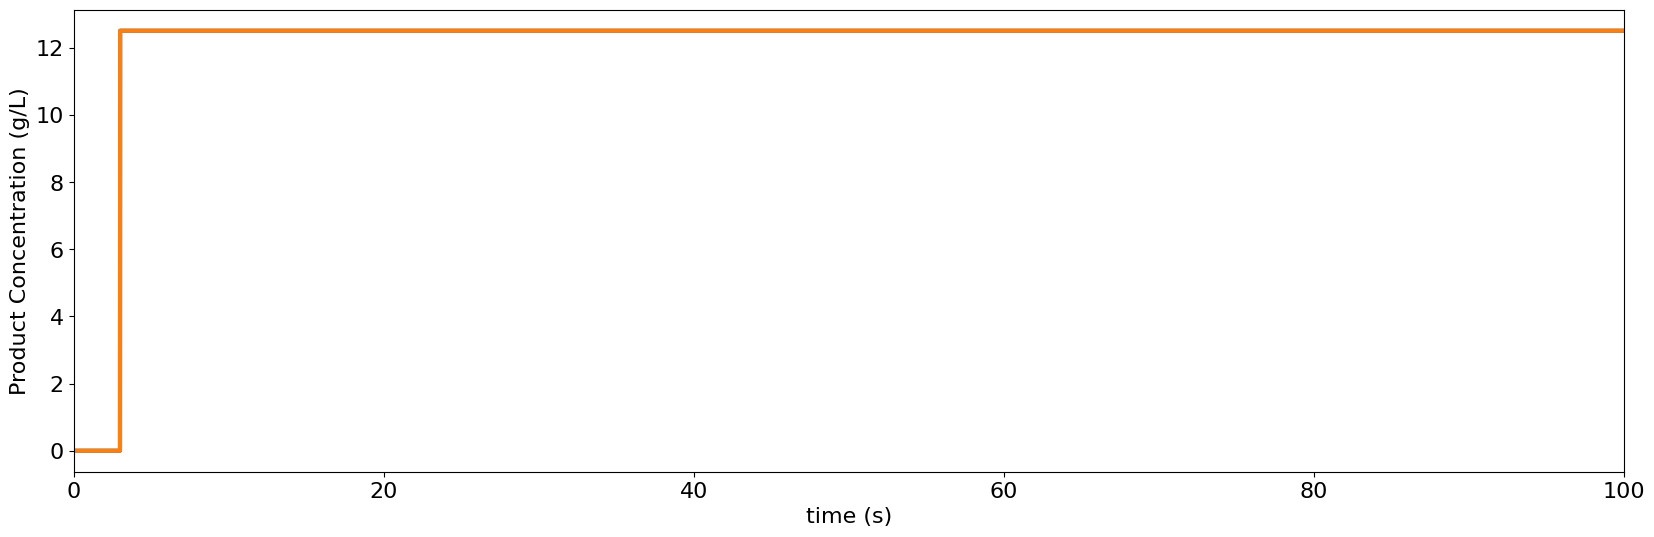

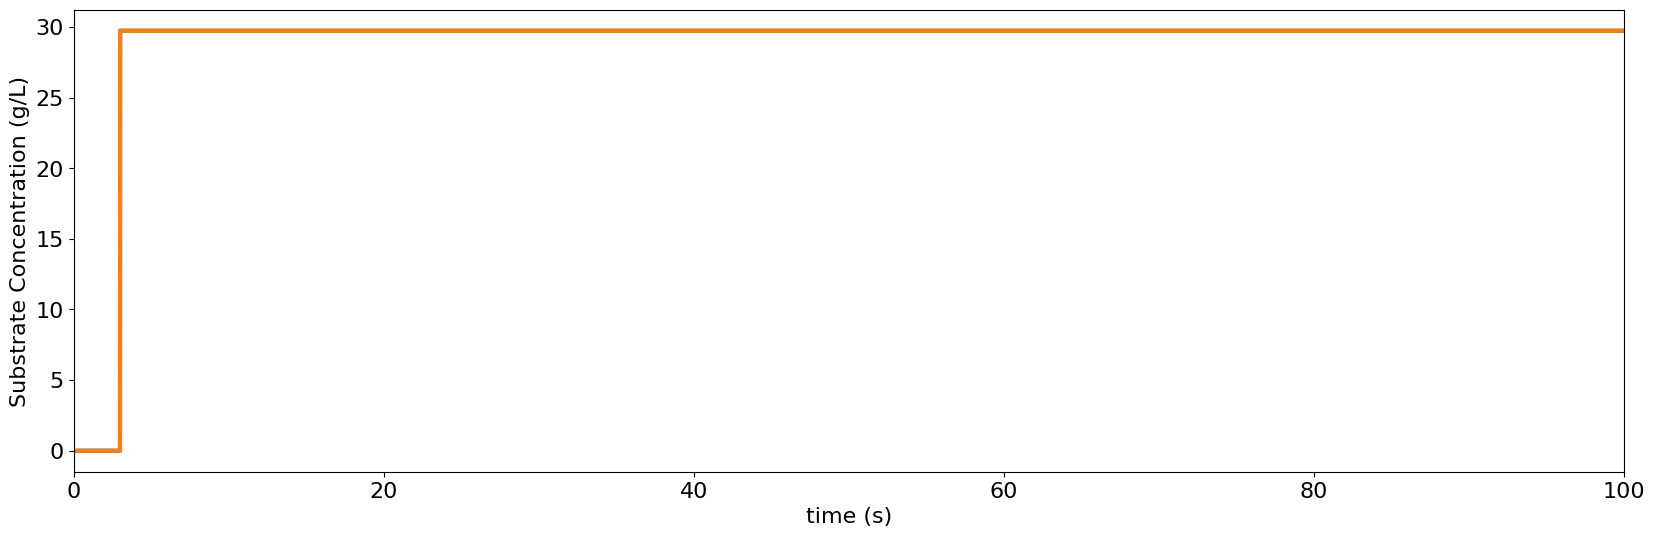

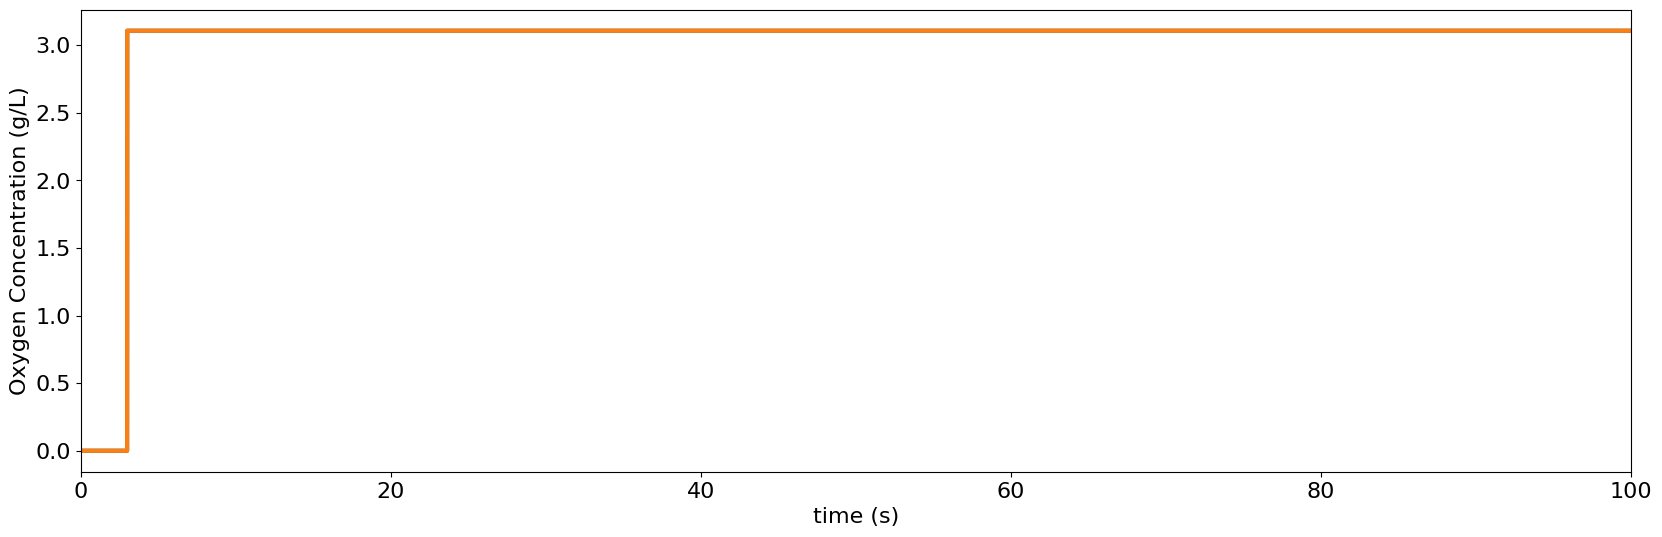

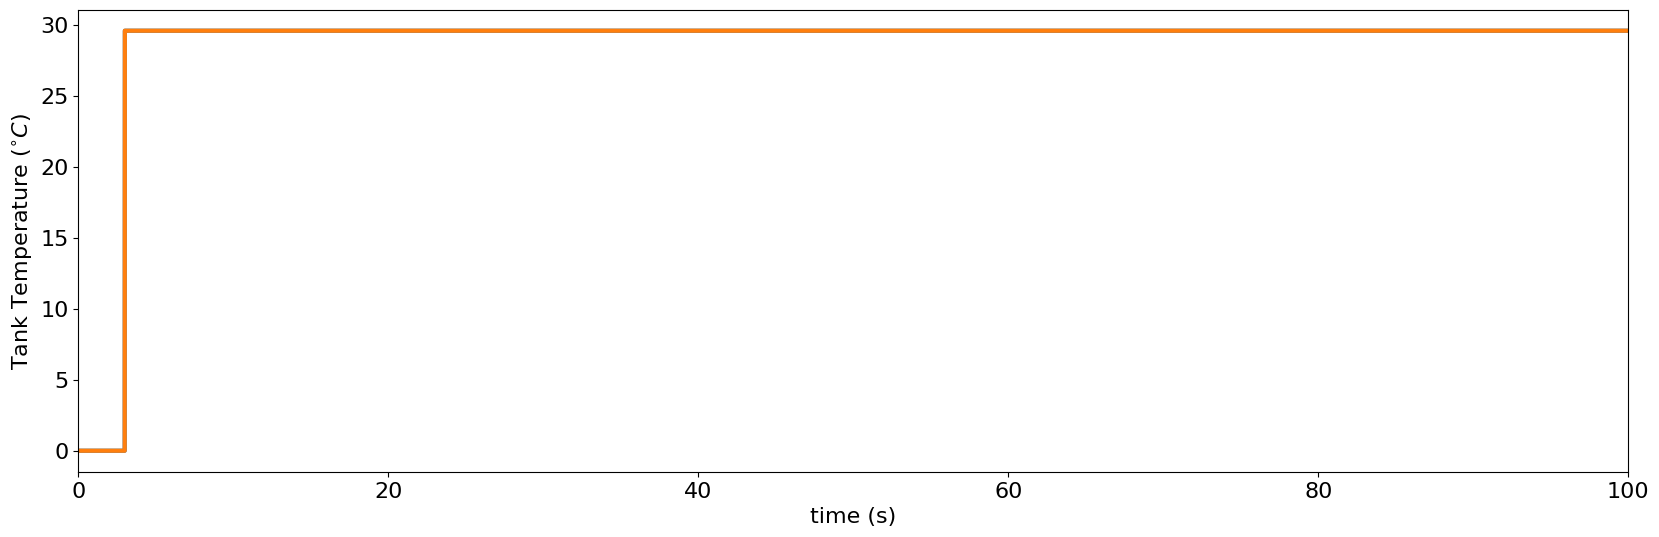

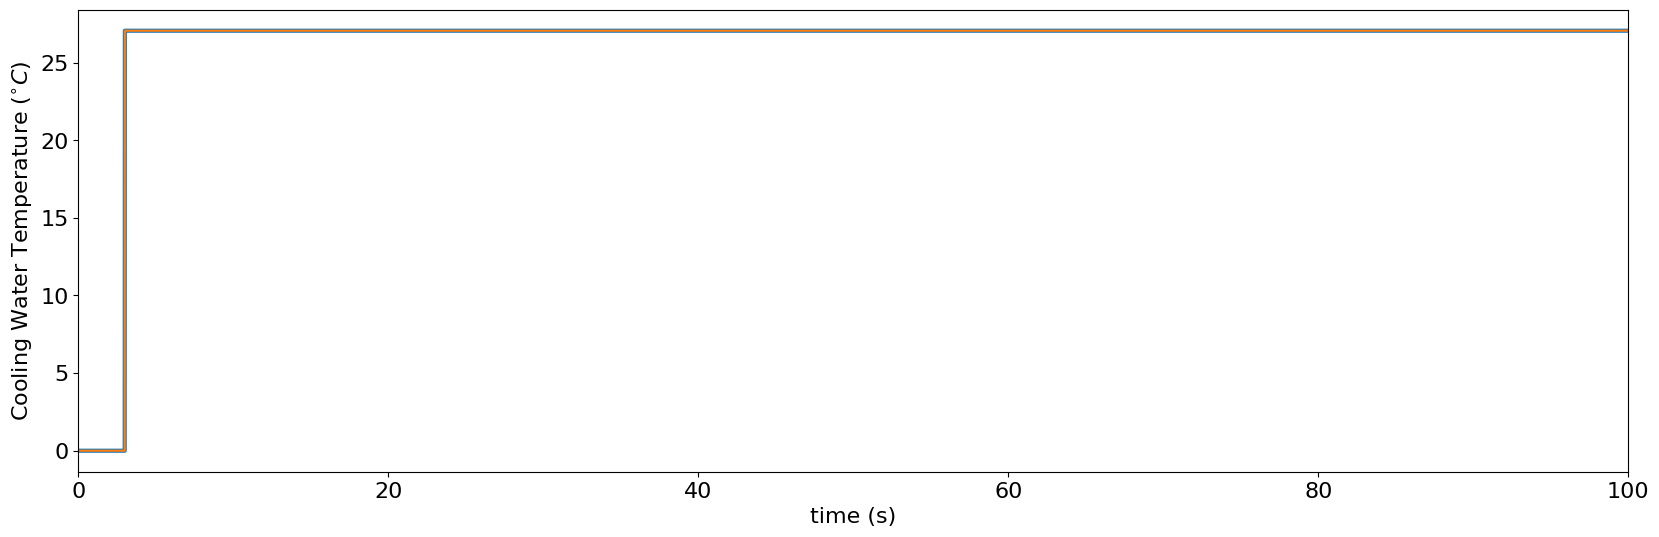

In [8]:
### Ploting ###

plt.figure(figsize=(20, 6))
plt.plot(t,result[0],lw=3)
plt.plot(t,result_sp[0],lw=3)
plt.xlim([0,t_final])
plt.xlabel("time (s)")
plt.ylabel("Volume of Reactor (L)")

plt.figure(figsize=(20, 6))
plt.plot(t,result[1],lw=3)
plt.plot(t,result_sp[1],lw=3)
plt.xlim([0,t_final])
plt.xlabel("time (s)")
plt.ylabel("Biomass Concentration (g/L)")

plt.figure(figsize=(20, 6))
plt.plot(t,result[2],lw=3)
plt.plot(t,result_sp[2],lw=3)
plt.xlim([0,t_final])
plt.xlabel("time (s)")
plt.ylabel("Product Concentration (g/L)")

plt.figure(figsize=(20, 6))
plt.plot(t,result[3],lw=3)
plt.plot(t,result_sp[3],lw=3)
plt.xlim([0,t_final])
plt.xlabel("time (s)")
plt.ylabel("Substrate Concentration (g/L)")

plt.figure(figsize=(20, 6))
plt.plot(t,result[4],lw=3)
plt.plot(t,result_sp[4],lw=3)
plt.xlim([0,t_final])
plt.xlabel("time (s)")
plt.ylabel("Oxygen Concentration (g/L)")

plt.figure(figsize=(20, 6))
plt.plot(t,result[5],lw=3)
plt.plot(t,result_sp[5],lw=3)
plt.xlim([0,t_final])
plt.xlabel("time (s)")
plt.ylabel("Tank Temperature ($^{\circ} C$)")

plt.figure(figsize=(20, 6))
plt.plot(t,result[6],lw=3)
plt.plot(t,result_sp[6])
plt.xlim([0,t_final])
plt.xlabel("time (s)")
plt.ylabel("Cooling Water Temperature ($^{\circ} C$)")
plt.show()


## Question 3

Let's see the difference in the product concentration with disturbances to $C_s$ vs. $T$

In [9]:
x0_baseline = [1000, 0.90467678228155, 12.51524128083789, 29.73892382828279, 3.10695341758232, 29.57321214183856, 27.05393890970931]

x0_disturb_cs = x0_baseline.copy()
x0_disturb_cs[3] += 5

x0_disturb_temp = x0_baseline.copy()
x0_disturb_temp[5] += 2

t_final = 100

t_baseline, result_baseline, _ = dynamic_model([0, t_final], x0_baseline)
t_cs, result_cs, _ = dynamic_model([0, t_final], x0_disturb_cs)
t_temp, result_temp, _ = dynamic_model([0, t_final], x0_disturb_temp)

T_baseline, T_cs, T_temp = result_baseline[5, :], result_cs[5, :], result_temp[5, :]
Cp_baseline, Cp_cs, Cp_temp = result_baseline[2, :], result_cs[2, :], result_temp[2, :]


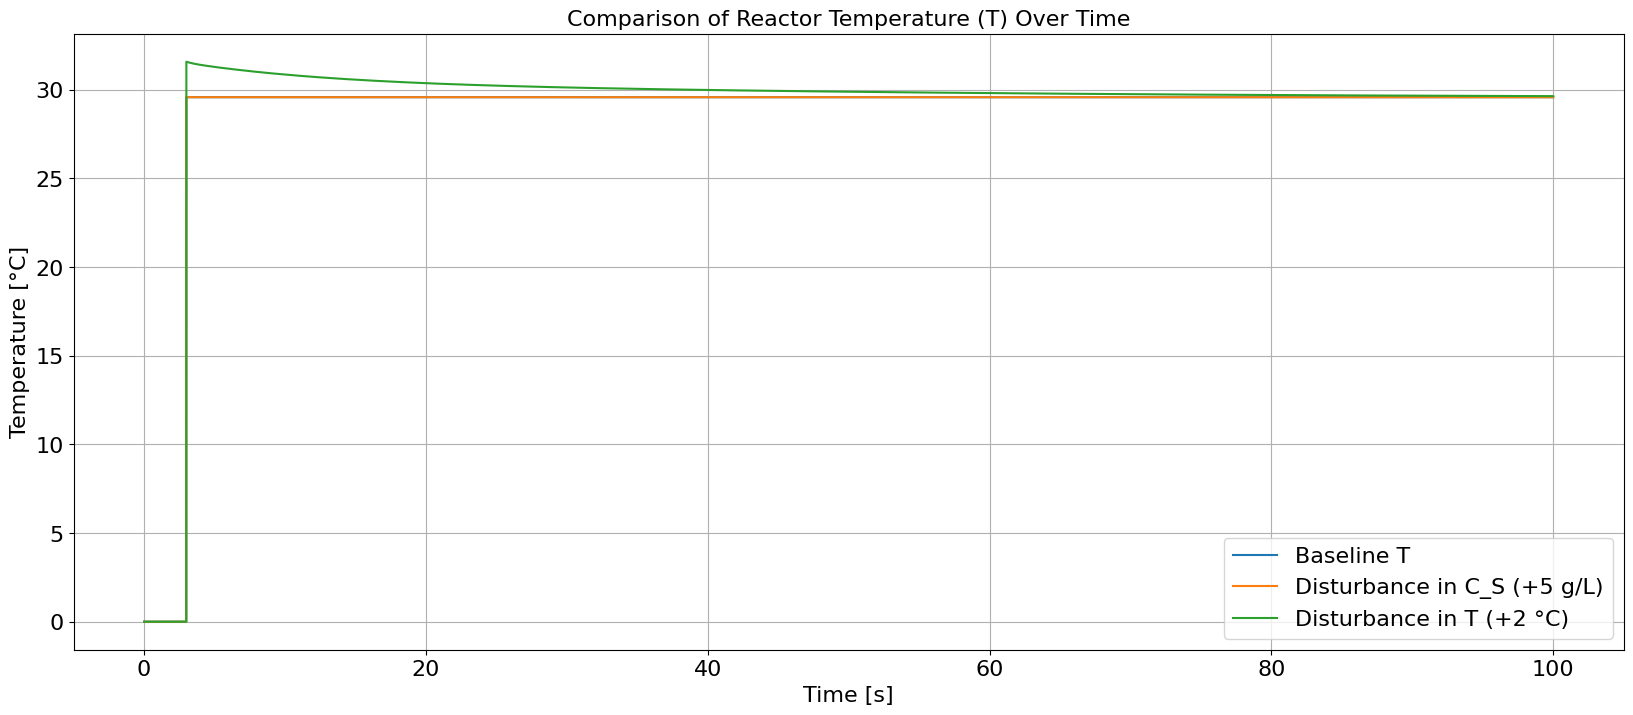

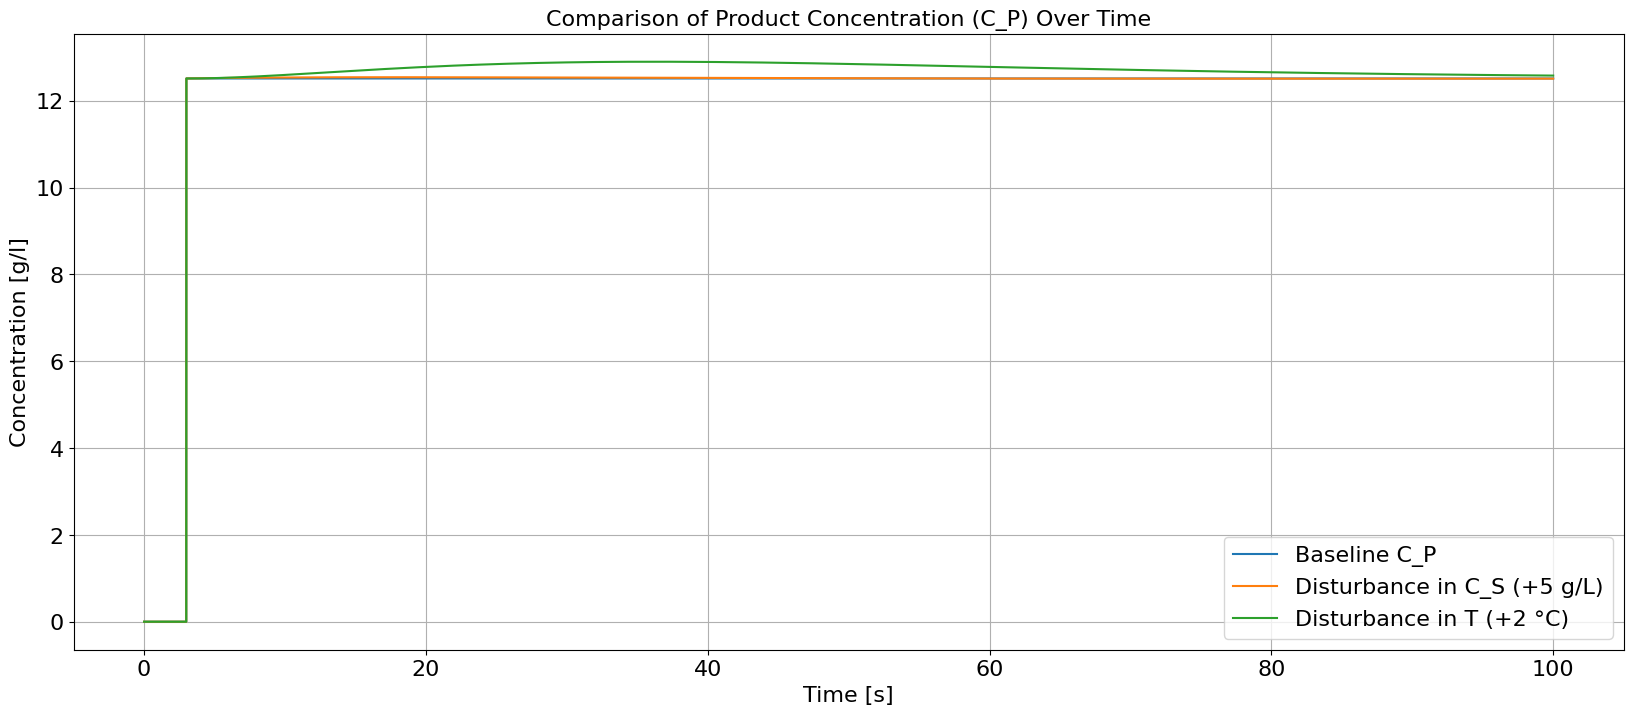

In [10]:
plt.figure(figsize=(20, 8))
plt.plot(t_baseline, T_baseline, label="Baseline T")
plt.plot(t_cs, T_cs, label="Disturbance in C_S (+5 g/L)")
plt.plot(t_temp, T_temp, label="Disturbance in T (+2 °C)")
plt.title("Comparison of Reactor Temperature (T) Over Time")
plt.xlabel("Time [s]")
plt.ylabel("Temperature [°C]")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(20, 8))
plt.plot(t_baseline, Cp_baseline, label="Baseline C_P")
plt.plot(t_cs, Cp_cs, label="Disturbance in C_S (+5 g/L)")
plt.plot(t_temp, Cp_temp, label="Disturbance in T (+2 °C)")
plt.title("Comparison of Product Concentration (C_P) Over Time")
plt.xlabel("Time [s]")
plt.ylabel("Concentration [g/l]")
plt.legend()
plt.grid(True)
plt.show()


We will also get the percentage difference for a quantitative difference in $T$ and $C_P$ as a result of the disturbance in $T_f$ and $C_S$ at the feed

In [11]:
baseline_T = result_baseline[5, -1]
csin_T = result_cs[5, -1]
temp_T = result_temp[5, -1]

baseline_Cp = result_baseline[2, -1]
csin_Cp = result_cs[2, -1]
temp_Cp = result_temp[2, -1]

In [12]:
def percent_change(baseline, disturbed):
    return ((disturbed - baseline) / baseline) * 100

percent_change_T_csin = percent_change(baseline_T, csin_T)
percent_change_T_temp = percent_change(baseline_T, temp_T)

percent_change_Cp_csin = percent_change(baseline_Cp, csin_Cp)
percent_change_Cp_temp = percent_change(baseline_Cp, temp_Cp)

print(f"Percent change in T for disturbance in C_S (+20 g/L): {percent_change_T_csin:.2f}%")
print(f"Percent change in T for disturbance in T (-2°C): {percent_change_T_temp:.2f}%")
print(f"Percent change in C_P for disturbance in C_S (+20 g/L): {percent_change_Cp_csin:.2f}%")
print(f"Percent change in C_P for disturbance in T (-2°C): {percent_change_Cp_temp:.2f}%")


Percent change in T for disturbance in C_S (+20 g/L): -0.01%
Percent change in T for disturbance in T (-2°C): 0.20%
Percent change in C_P for disturbance in C_S (+20 g/L): -0.03%
Percent change in C_P for disturbance in T (-2°C): 0.53%


## Question 4

In [143]:
def dynamic_model_with_step(time, x0):
    result_sp = set_point(time, x0)
    result = np.zeros((7, T_DELAY * (T_POINT - 1)))
    
    for i in range(time[1] - T_DELAY):
        if i == 0:
            x0 = x0
        
        V, Cx, Cp, Cs, Co2, T, Tag = current_output(i, result)
        Vsp, Cxsp, Cpsp, Cssp, Co2sp, Tsp, Tagsp = current_output(i, result_sp)
        
        Fi = lambda t: 51
        Fe = lambda t: 51 if t < 10 else 51 * 1.1
        T_in = lambda t: 25
        cS_in = lambda t: 60
        Fag = lambda t: 18
        
        result = solve_step([i, i + 1], x0, Fi, Fe, T_in, cS_in, Fag, result)
        x0 = result[:, -1]
    
    t = np.linspace(time[0], time[1], (time[1] - time[0]) * (T_POINT - 1) + 1)
    return t, result, result_sp


In [144]:
def current_output(time, result):
    process_time = int(time * (T_POINT - 1))
    return result[:, process_time:int((time + 1) * (T_POINT - 1) + 1)]

t_final = 100
t_step, result_step, result_sp_step = dynamic_model_with_step([0, t_final], x0)
V_step = result_step[0, :]

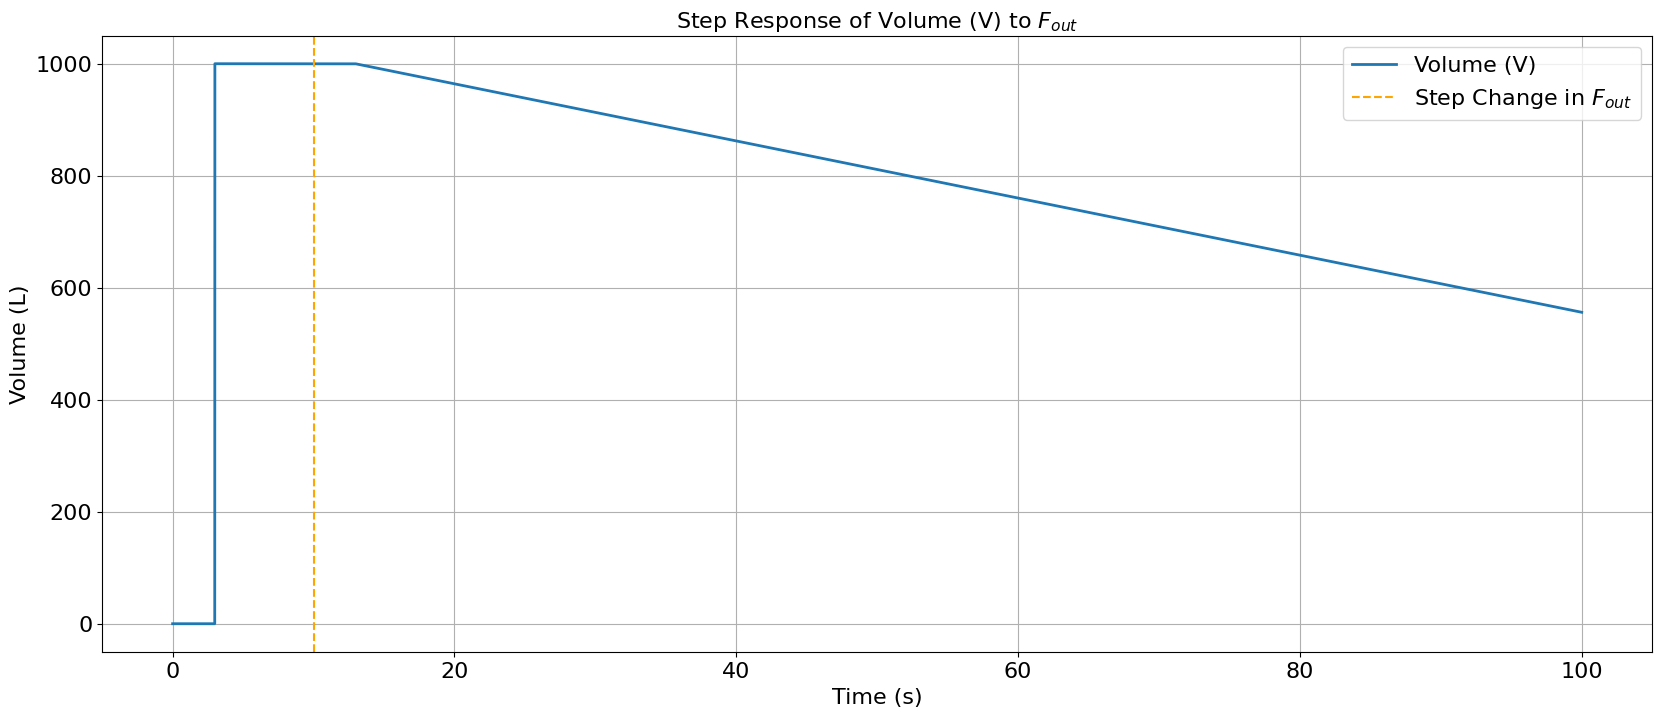

In [145]:
plt.figure(figsize=(20, 8))
plt.plot(t_step, V_step, label="Volume (V)", linewidth=2)
plt.axvline(10, color='orange', linestyle='--', label="Step Change in $F_{out}$")
plt.title("Step Response of Volume (V) to $F_{out}$")
plt.xlabel("Time (s)")
plt.ylabel("Volume (L)")
plt.legend()
plt.grid(True)
plt.show()

#### Attempt 1 at finding PID Parameters

In [149]:
V_step = result_step[0, :]

delta_F_out = 51 * 0.1
delta_V = V_step[-1] - 1000
K = delta_V / delta_F_out

target_value = 1000 + 0.63 * delta_V
time_to_63 = t_step[np.where(V_step >= target_value)[0][0]]

threshold = 0.01 * delta_V
time_delay_index = np.where(V_step > V_step[0] + threshold)[0][0]
time_delay = t_step[time_delay_index]

print(f"Steady-State Gain (K): {K} L/(L/h)")
print(f"Time Delay (theta): {time_delay} s")
print(f"Time Constant (tau): {time_to_63 - time_delay} s")



Steady-State Gain (K): -87.03357535853537 L/(L/h)
Time Delay (theta): 0.0 s
Time Constant (tau): 3.0000000000000004 s


#### Attempt 2 at finding PID Parameters

In [153]:
V_step = result_step[0, :]

delta_F_out = 51 * 0.1
delta_V = V_step[-1] - V_step[0]
K = delta_V / delta_F_out

target_value = V_step[0] + 0.63 * delta_V
time_to_63 = t_step[np.where(V_step >= target_value)[0][0]]

threshold = 0.01 * delta_V
time_delay_index = np.where(V_step > V_step[0] + threshold)[0][0]
time_delay = t_step[time_delay_index]

print(f"Steady-State Gain (K): {K} L/(L/h)")
print(f"Time Delay (theta): {time_delay} s")
print(f"Time Constant (tau): {time_to_63 - time_delay} s")


Steady-State Gain (K): 109.04485601401362 L/(L/h)
Time Delay (theta): 3.0000000000000004 s
Time Constant (tau): 0.0 s


#### Attempt 2's time delay makes sense with the plot. However, I think attempt 1 is more accurate because it depicts an accurate negative gain and uses an initial volume of 1000 instead of 1. I believe the plot is flawed. 

In [166]:
def FC(V, V_SP, F_out0, Kp, Ki, integral_error, dt):
    error = V_SP - V
    integral_error += error * dt
    F_out = F_out0 + Kp * error + Ki * integral_error
    return F_out, integral_error

In [169]:
V_SP = 1000
F_out0 = 51
Kp = 0.9 / K # given by ziegler-nichols method
Ki = 0.3 / K # given by ziegler-nichols method
integral_error = 0


def dynamic_model_with_PI(time, x0):
    result = np.zeros([7, T_DELAY * (T_POINT - 1)])
    dt = 1
    global integral_error
    integral_error = 0

    for i in range(time[1] - T_DELAY):
        if i == 0:
            x0 = x0

        V, _, _, _, _, _, _ = current_output(i, result)
        F_out, integral_error = FC(V[0], V_SP, F_out0, Kp, Ki, integral_error, dt)

        Fi = lambda t: 51
        Fe = lambda t: F_out
        T_in = lambda t: 25
        cS_in = lambda t: 60
        Fag = lambda t: 18

        result = solve_step([i, i + 1], x0, Fi, Fe, T_in, cS_in, Fag, result)
        x0 = result[:, -1]

    t = np.linspace(time[0], time[1], (time[1] - time[0]) * (T_POINT - 1) + 1)
    return t, result

In [170]:
t_final = 100
t_PI, result_PI = dynamic_model_with_PI([0, t_final], x0)

V_PI = result_PI[0, :]
F_out_PI = F_out0 + Kp * (V_SP - V_PI) + Ki * np.cumsum(V_SP - V_PI) * (t_PI[1] - t_PI[0])

/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_27509/3515846618.py:52: RuntimeWarning: overflow encountered in scalar power
  cst  = c0st * 10**(-sumaHiIi)
/Users/rahilshaik/cbe162/venv/lib/python3.12/site-packages/scipy/integrate/_ivp/common.py:347: RuntimeWarning: invalid value encountered in subtract
  diff = f_new - f[:, None]


ValueError: array must not contain infs or NaNs

In [ ]:

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_PI, V_PI, label="Process Variable (V)", linewidth=2)
plt.axhline(V_SP, color='red', linestyle='--', label="Setpoint (V_SP)")
plt.title("Closed-Loop Response of Volume (V) with PI Controller")
plt.xlabel("Time (s)")
plt.ylabel("Volume (L)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(t_PI, F_out_PI, label="Manipulated Variable (F_out)", linewidth=2)
plt.title("Outflow Rate (F_out) Controlled by PI")
plt.xlabel("Time (s)")
plt.ylabel("Outflow Rate (L/h)")
plt.legend()
plt.grid(True)
plt.show()
